In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
import os
os.chdir('/content/drive/My Drive/Data Analysis Files')

 Load and Inspect the Data

In [15]:
# Import necessary libraries
import pandas as pd

# Load the data
file_path = 'Online_Retail[1].xlsx'
data = pd.read_excel(file_path)

# Inspect the first few rows
print(data.head())

# Check the shape of the dataset
print("Dataset Shape:", data.shape)

# Get summary statistics
print(data.info())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
Dataset Shape: (541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
--

Clean the Data

In [8]:
# Check for missing values
print(data.isnull().sum())

# Drop rows with missing values
data_cleaned = data.dropna()

# Remove duplicate entries
data_cleaned = data_cleaned.drop_duplicates()

# Filter out records with invalid or canceled transactions (e.g., Quantity <= 0)
data_cleaned = data_cleaned[(data_cleaned['Quantity'] > 0) & (~data_cleaned['InvoiceNo'].astype(str).str.startswith('C'))]

# Verify the cleaned data
print("Cleaned Dataset Shape:", data_cleaned.shape)
print(data_cleaned.head())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Cleaned Dataset Shape: (392732, 8)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       

Feature Engineering

In [9]:
# Calculate Total Spending (UnitPrice * Quantity)
data_cleaned['TotalSpent'] = data_cleaned['Quantity'] * data_cleaned['UnitPrice']

# Group by CustomerID to calculate Recency, Frequency, and Monetary Value
from datetime import datetime

# Convert InvoiceDate to datetime format
data_cleaned['InvoiceDate'] = pd.to_datetime(data_cleaned['InvoiceDate'])

# Set a reference date for calculating recency
reference_date = data_cleaned['InvoiceDate'].max() + pd.Timedelta(days=1)

# Aggregate data
customer_data = data_cleaned.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (reference_date - x.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    MonetaryValue=('TotalSpent', 'sum')
).reset_index()

# Inspect the aggregated data
print(customer_data.head())

   CustomerID  Recency  Frequency  MonetaryValue
0     12346.0      326          1       77183.60
1     12347.0        2          7        4310.00
2     12348.0       75          4        1797.24
3     12349.0       19          1        1757.55
4     12350.0      310          1         334.40


Normalize the Features

In [10]:
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = ['Recency', 'Frequency', 'MonetaryValue']

# Normalize the features
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[features])

# Convert back to DataFrame for clarity
customer_data_scaled = pd.DataFrame(customer_data_scaled, columns=features)

# Inspect the normalized data
print(customer_data_scaled.head())

    Recency  Frequency  MonetaryValue
0  2.334858  -0.424675       8.363977
1 -0.905199   0.354080       0.251779
2 -0.175186  -0.035297      -0.027938
3 -0.735196  -0.424675      -0.032357
4  2.174855  -0.424675      -0.190780


Apply K-Means Clustering

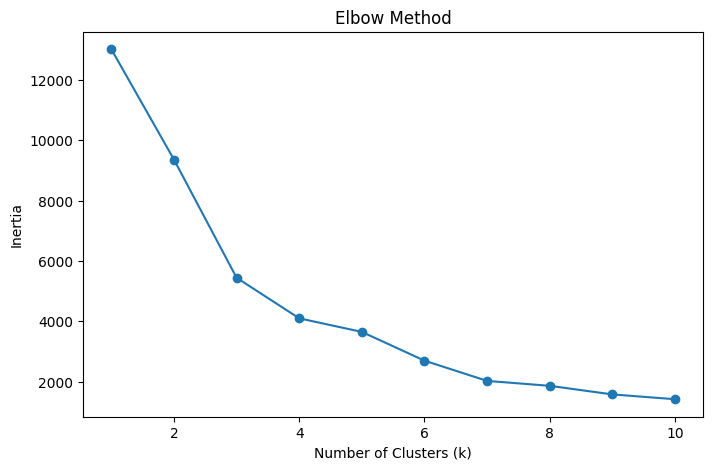

   CustomerID  Recency  Frequency  MonetaryValue  Cluster
0     12346.0      326          1       77183.60        0
1     12347.0        2          7        4310.00        3
2     12348.0       75          4        1797.24        3
3     12349.0       19          1        1757.55        3
4     12350.0      310          1         334.40        1


In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using the Elbow Method
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_data_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# Based on the elbow plot, choose the optimal number of clusters (e.g., k=4)
optimal_k = 4

# Apply K-means with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)

# Inspect the clusters
print(customer_data.head())

Visualize the Clusters

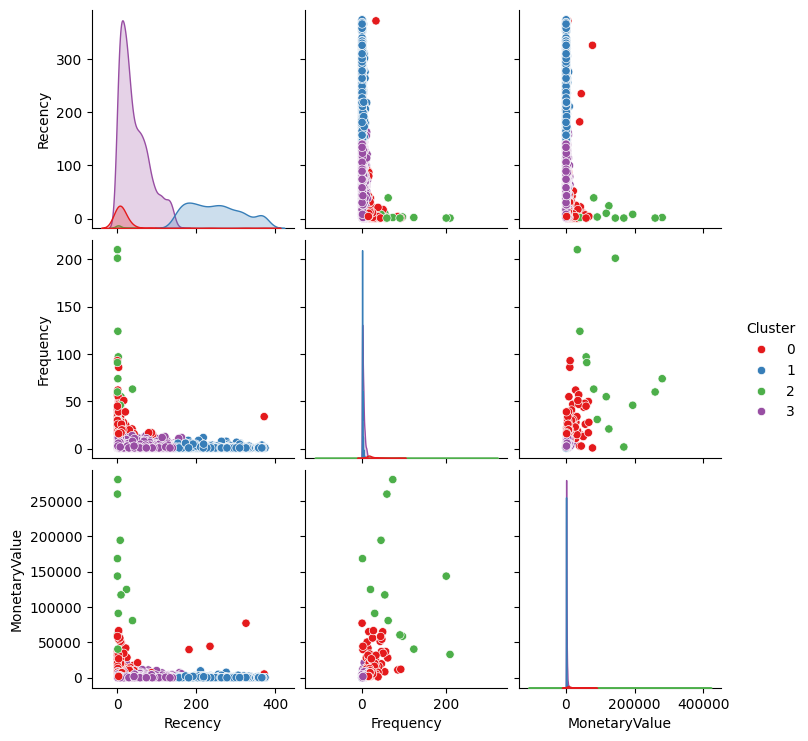

<ipython-input-12-780ae133dd75>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=customer_data, palette='Set1')
<ipython-input-12-780ae133dd75>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=customer_data, palette='Set1')
<ipython-input-12-780ae133dd75>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=customer_data, palette='Set1')


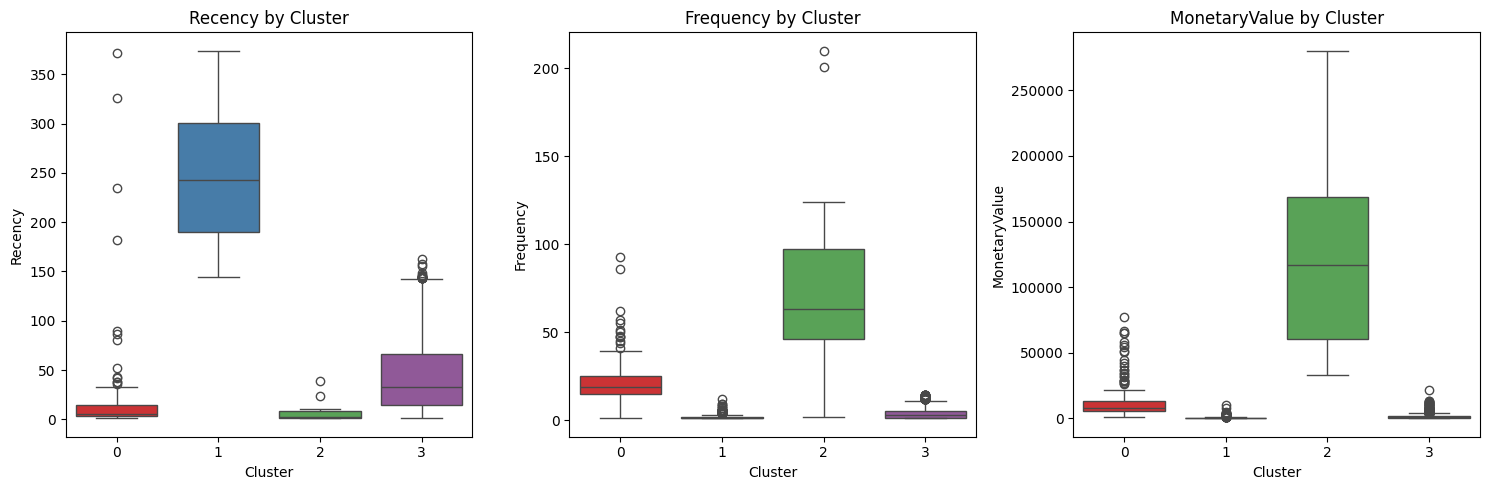

In [12]:
import seaborn as sns

# Pairplot to visualize clusters
sns.pairplot(customer_data, hue='Cluster', vars=features, palette='Set1')
plt.show()

# Boxplots to compare cluster characteristics
plt.figure(figsize=(15, 5))

for i, feature in enumerate(features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Cluster', y=feature, data=customer_data, palette='Set1')
    plt.title(f'{feature} by Cluster')

plt.tight_layout()
plt.show()

Describe Cluster Characteristics

In [13]:
# Group by cluster and calculate mean values for each feature
cluster_summary = customer_data.groupby('Cluster')[features].mean().round(2)

# Add cluster size
cluster_summary['ClusterSize'] = customer_data['Cluster'].value_counts().sort_index()

# Display the summary
print(cluster_summary)

         Recency  Frequency  MonetaryValue  ClusterSize
Cluster                                                
0          15.67      22.05       12435.09          211
1         248.56       1.55         476.33         1062
2           7.38      82.69      127187.96           13
3          43.91       3.66        1344.28         3053
